In [1]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from os import chdir, getcwd
from dill import dump, load


<Axes: >

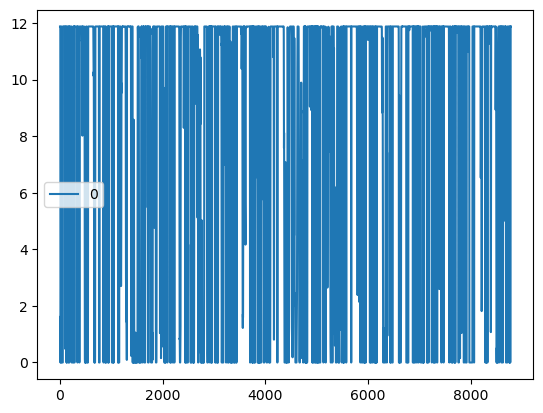

In [2]:
dir = getcwd()
chdir(dir+'/PreOptimisationDataStore')
with open('WeatherData.pickle', 'rb') as f:
    df = load(f)
chdir(dir)
df.plot()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Simulate some hourly wind speed data (8760 hours = 1 year)
# In practice, load your real wind speed data
wind_speed_data = df.values  # Simulating 1 year of wind speed data (8760 hours)

# Normalize the data between 0 and 1
scaler = MinMaxScaler()
wind_speed_data = wind_speed_data.reshape(-1, 1)  # Reshape for scaling
scaled_wind_speed = scaler.fit_transform(wind_speed_data).flatten()  # Flatten after scaling

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(scaled_wind_speed) * 0.8)
train_data, test_data = scaled_wind_speed[:train_size], scaled_wind_speed[train_size:]

# Dataset class for wind speed
class WindSpeedDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        self.data = data
        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        return len(self.data) - self.input_window - self.output_window

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_window]  # Input: past input_window hours
        y = self.data[idx + self.input_window:idx + self.input_window + self.output_window]  # Output: next output_window hours
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
input_window = 168  # Past 168 hours (1 week) as input
output_window = 24  # Predict the next 168 hours (1 week)

# Datasets and DataLoaders
train_dataset = WindSpeedDataset(train_data, input_window, output_window)
test_dataset = WindSpeedDataset(test_data, input_window, output_window)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [4]:
class CNNWindSpeedPredictor(nn.Module):
    def __init__(self, num_channels=64, kernel_size=3, num_conv_layers=3):
        super(CNNWindSpeedPredictor, self).__init__()

        layers = []
        in_channels = 1  # One input feature: wind speed

        # Create multiple 1D convolutional layers
        for i in range(num_conv_layers):
            layers.append(
                nn.Conv1d(in_channels=in_channels, out_channels=num_channels, kernel_size=kernel_size, padding=kernel_size//2)
            )
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool1d(kernel_size=2))
            in_channels = num_channels

        self.conv = nn.Sequential(*layers)

        # Fully connected layers to produce the output prediction
        self.fc = nn.Sequential(
            nn.Linear(num_channels * (input_window // (2 ** num_conv_layers)), 512),
            nn.ReLU(),
            nn.Linear(512, output_window)  # Output window is the next 168 hours
        )

    def forward(self, x):
        # x shape: (batch_size, input_window) -> (batch_size, 1, input_window)
        x = x.unsqueeze(1)  # Add channel dimension (batch_size, 1, input_window)
        x = self.conv(x)     # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        x = self.fc(x)       # Pass through fully connected layers
        return x

# Initialize the model
model = CNNWindSpeedPredictor()


In [5]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.1894
Epoch [2/20], Loss: 0.1486
Epoch [3/20], Loss: 0.1413
Epoch [4/20], Loss: 0.1321
Epoch [5/20], Loss: 0.1242
Epoch [6/20], Loss: 0.1097
Epoch [7/20], Loss: 0.0925
Epoch [8/20], Loss: 0.0752
Epoch [9/20], Loss: 0.0622
Epoch [10/20], Loss: 0.0511
Epoch [11/20], Loss: 0.0425
Epoch [12/20], Loss: 0.0365
Epoch [13/20], Loss: 0.0319
Epoch [14/20], Loss: 0.0279
Epoch [15/20], Loss: 0.0254
Epoch [16/20], Loss: 0.0229
Epoch [17/20], Loss: 0.0211
Epoch [18/20], Loss: 0.0194
Epoch [19/20], Loss: 0.0181
Epoch [20/20], Loss: 0.0170


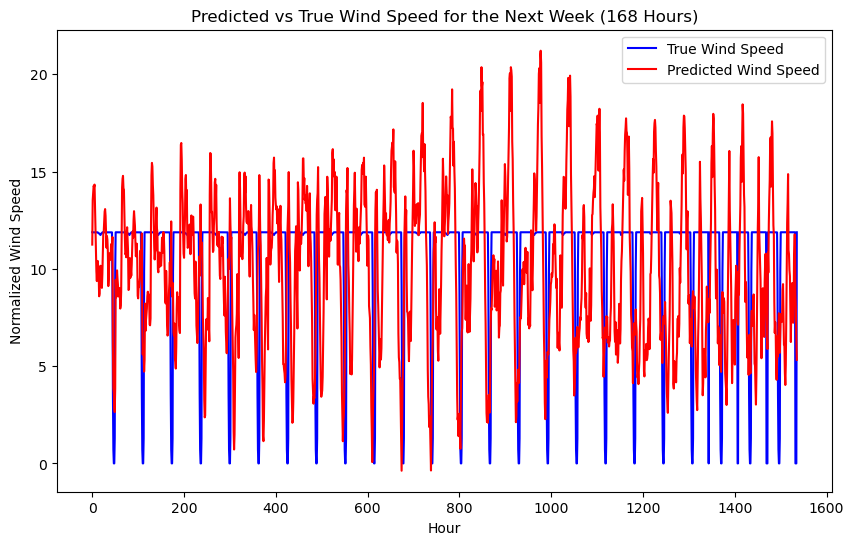

In [6]:
# Function to plot predictions vs actual data
def plot_predictions(preds, true_values):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Wind Speed', color='blue')
    plt.plot(preds, label='Predicted Wind Speed', color='red')
    plt.title('Predicted vs True Wind Speed for the Next Week (168 Hours)')
    plt.xlabel('Hour')
    plt.ylabel('Normalized Wind Speed')
    plt.legend()
    plt.show()

# Evaluate the model and plot predictions
model.eval()
with torch.no_grad():
    # Get one batch from the test data (you can use more)
    for inputs, targets in test_loader:
        outputs = model(inputs)  # Get predictions for the next 168 hours
        inputs = inputs.numpy()  # Convert to numpy
        outputs = outputs.numpy()  # Convert to numpy
        targets = targets.numpy()  # Convert to numpy
        break  # Only take one batch for demonstration

    # Inverse transform to original scale (optional)
    predicted_wind_speed = scaler.inverse_transform(outputs.T).flatten()
    true_wind_speed = scaler.inverse_transform(targets.T).flatten()

    # Plot the predicted vs true wind speed
    plot_predictions(predicted_wind_speed, true_wind_speed)
